In [ ]:
import torch
import matplotlib.pyplot as plt
from einops import rearrange
from tqdm import tqdm

from bliss.datasets.lsst import convert_flux_to_mag
from bliss.datasets.io import load_dataset_npz

In [ ]:
# from bliss.datasets.io import load_dataset_npz
# images = load_dataset_npz("../../data/datasets/test_ds_23.npz")['images']
# images.shape

In [ ]:
ds = torch.load("../../data/cache/sampling_test2.pt")

In [ ]:
ds.keys()

dict_keys(['samples', 'truth', 'snr', 'bld', 'n_source_probs', 'locs_mean', 'locs_sd'])

In [ ]:
ds['samples']['flux'].shape

torch.Size([100, 44429, 1])

In [ ]:
_bld = ds['bld'][:, 0]
_bld.shape

torch.Size([44429])

In [ ]:
_snr = ds['snr'][:, 0]
_snr.shape

torch.Size([44429])

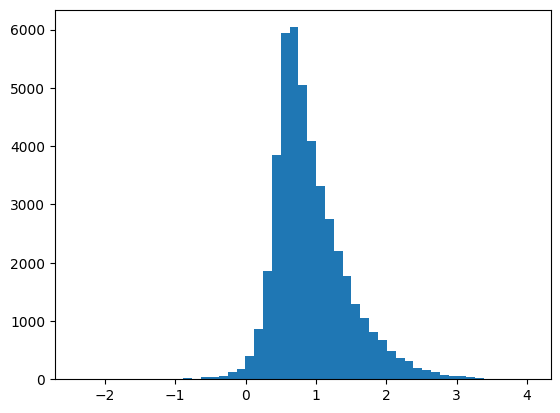

In [ ]:
mask = _snr > 0 
plt.hist(_snr[mask].log10(), bins=51);

In [ ]:
_fluxes = ds['samples']['flux']
_fluxes.shape

torch.Size([100, 44429, 1])

In [ ]:
fluxerrs = (_fluxes[:, :, 0] / _snr.reshape(1, -1))
fluxerr = fluxerrs.nanmedian()
fluxerr

tensor(3797.5581)

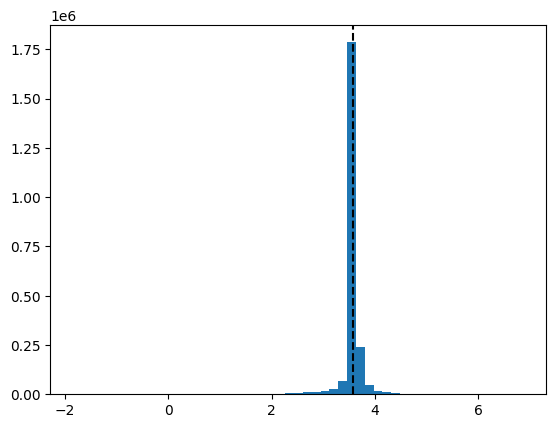

In [ ]:
x = fluxerrs.flatten()
__mask = ~x.isnan() & ~x.isinf() & ~x.isneginf()
plt.hist(x[__mask].log10(), bins=51);
plt.axvline(fluxerr.log10(), linestyle='--', color='k')

In [ ]:
_fluxes[:, 121, 0] # seems pretty consistent across catalogs

tensor([72350.4453,        nan,        nan, 68120.1250, 71504.6719,        nan,
        70363.9922, 70597.6562, 70215.8125, 71519.2266, 67170.0703, 62034.3125,
               nan, 67794.4141, 69355.8984, 71017.6094, 66120.1250,        nan,
        67906.4062,        nan, 69030.1406, 67220.1797, 68710.8203,        nan,
               nan,        nan, 63933.7422, 69406.3047,        nan,        nan,
               nan, 67510.0547, 71405.1094,        nan, 70758.4609,        nan,
        65829.1797, 66943.1797,        nan, 68667.5781, 68495.2500, 67096.3984,
        70500.3750,        nan, 64180.2930,        nan, 58545.5000, 68806.4453,
        56819.7070, 69979.1641, 51540.3398, 67674.6406,        nan, 70145.1172,
        65992.3047, 65053.0898,        nan, 64710.3320, 64958.0078, 71734.5078,
        62850.7734, 70427.3516, 58609.4062, 68632.5938, 70576.5938,        nan,
        67088.8125, 60332.4453,        nan,        nan, 66578.3516, 69323.3047,
               nan, 68490.9609, 69990.71

In [ ]:
convert_flux_to_mag(_fluxes[:, 121, 0])

tensor([24.9862,     nan,     nan, 25.0517, 24.9990,     nan, 25.0165, 25.0129,
        25.0188, 24.9988, 25.0669, 25.1533,     nan, 25.0569, 25.0321, 25.0064,
        25.0840,     nan, 25.0551,     nan, 25.0373, 25.0661, 25.0423,     nan,
            nan,     nan, 25.1205, 25.0314,     nan,     nan,     nan, 25.0614,
        25.0005,     nan, 25.0104,     nan, 25.0888, 25.0706,     nan, 25.0430,
        25.0457, 25.0681, 25.0144,     nan, 25.1163,     nan, 25.2161, 25.0408,
        25.2486, 25.0224, 25.3545, 25.0588,     nan, 25.0199, 25.0861, 25.1017,
            nan, 25.1074, 25.1033, 24.9955, 25.1391, 25.0155, 25.2149, 25.0435,
        25.0132,     nan, 25.0682, 25.1835,     nan,     nan, 25.0765, 25.0326,
            nan, 25.0458, 25.0222, 25.0604,     nan, 25.0277,     nan, 25.0725,
        25.1268, 25.0295, 25.0050, 25.0727, 25.0235, 24.9968, 25.1757, 25.2232,
        25.1325, 25.0041, 25.2062, 25.0563, 25.0559, 25.0756,     nan, 25.0332,
        25.0245, 25.0278,     nan,     n

In [ ]:
ds['truth']['flux'][251, 0]

tensor(12919.2725)

In [ ]:
sum(ds['truth']['galaxy_bools'])

tensor([44429.])

In [ ]:
_snr[241]

tensor(2.7483)

In [ ]:
_bld[241]

tensor(0.0251)

(array([17797.,  5520.,  3276.,  2334.,  1812.,  1547.,  1222.,  1104.,
         1018.,   922.,   838.,   694.,   710.,   638.,   580.,   515.,
          529.,   485.,   455.,   473.,   433.,   413.,   402.,   357.,
          355.]),
 array([2.92062759e-06, 3.99736613e-02, 7.99444020e-02, 1.19915143e-01,
        1.59885883e-01, 1.99856624e-01, 2.39827365e-01, 2.79798090e-01,
        3.19768846e-01, 3.59739602e-01, 3.99710327e-01, 4.39681053e-01,
        4.79651809e-01, 5.19622564e-01, 5.59593260e-01, 5.99564016e-01,
        6.39534771e-01, 6.79505527e-01, 7.19476283e-01, 7.59446979e-01,
        7.99417734e-01, 8.39388490e-01, 8.79359186e-01, 9.19329941e-01,
        9.59300697e-01, 9.99271452e-01]),
 <BarContainer object of 25 artists>)

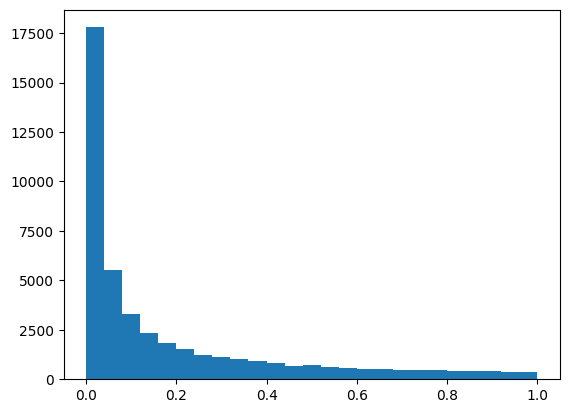

In [ ]:
plt.hist(_bld, bins=25)

## flux residuals

In [ ]:
sum(ds['truth']['galaxy_bools'][: ,0].bool())

tensor(44429)

In [ ]:
ds['samples']['flux'].shape

torch.Size([100, 44429, 1])

In [ ]:
mask = (ds['snr'][:, 0] > 0) & (ds['truth']['galaxy_bools'][:, 0].bool())

tflux = ds['truth']['flux'][mask, 0]
sfluxes = ds['samples']['flux'][:, mask, 0]
tflux.shape, sfluxes.shape
snr = ds['snr'][mask, 0]
bld = ds['bld'][mask, 0]

snr.shape, sfluxes.shape, tflux.shape, bld.shape

(torch.Size([44350]),
 torch.Size([100, 44350]),
 torch.Size([44350]),
 torch.Size([44350]))

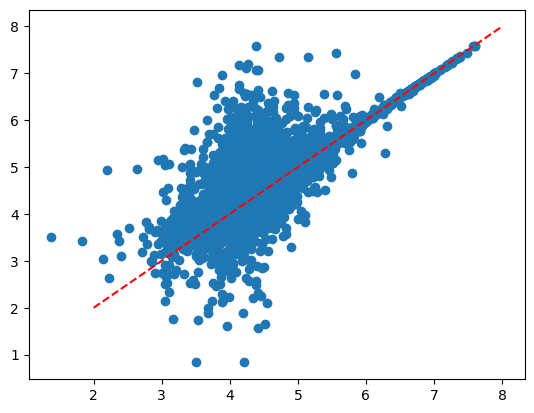

In [ ]:
# just look at scatter of mean  as a first pass
plt.scatter(tflux.log10(), sfluxes.nanquantile(q=0.5,axis=0).log10())
plt.plot([2, 8], [2, 8], 'r--')

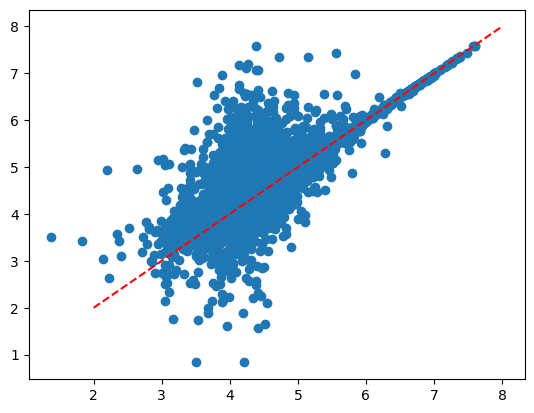

In [ ]:
plt.scatter(tflux.log10(), sfluxes.nanquantile(q=0.5,axis=0).log10())
plt.plot([2, 8], [2, 8], 'r--')

In [ ]:

# bins
snr_mask = (snr > 3) * (snr <= 1000)
_snr = snr[snr_mask]
_snr_log = torch.log10(_snr)
qs = torch.linspace(0, 1, 10)
snr_bins = torch.quantile(_snr_log, qs)
snr_middle = (snr_bins[1:] + snr_bins[:-1]) / 2


In [ ]:
f1 = rearrange(tflux, 'n -> 1 n')
res = (sfluxes - f1) / f1
_res = res[:, snr_mask]
_res.shape, res.shape

(torch.Size([100, 37645]), torch.Size([100, 44350]))

In [ ]:
sfluxes.shape, f1.shape

(torch.Size([100, 44350]), torch.Size([1, 44350]))

In [ ]:
# defaults correspond to 1 sigma in Gaussian distribution
def _calculate_statistics(sy, x, x_bins, qs=(0.159, 0.841)):
    medians, q1s, q3s = [], [], []
    for ii in range(len(x_bins) - 1):
        _mask = (x > x_bins[ii]) * (x < x_bins[ii + 1])
        masked_sy = sy[:, _mask]
        medians.append(torch.nanmedian(masked_sy.ravel()))
        q1s.append(torch.nanquantile(masked_sy.ravel(), qs[0]))
        q3s.append(torch.nanquantile(masked_sy.ravel(), qs[1]))
    return torch.tensor(medians), torch.tensor(q1s), torch.tensor(q3s)

In [ ]:
# defaults correspond to 1 sigma in Gaussian distribution
def _calculate_statistics2(sy, x, x_bins, qs=(0.159, 0.841)):
    medians, q1s, q3s = [], [], []
    for ii in range(len(x_bins) - 1):
        _mask = (x > x_bins[ii]) * (x < x_bins[ii + 1])
        masked_sy = sy[:, _mask]
        mu = torch.nanmean(masked_sy, axis=0)
        assert mu.ndim == 1

        medians.append(torch.nanmedian(mu))
        q1s.append(torch.nanquantile(mu, qs[0]))
        q3s.append(torch.nanquantile(mu, qs[1]))
    return torch.tensor(medians), torch.tensor(q1s), torch.tensor(q3s)

In [ ]:
# m, q1, q2 = _calculate_statistics(_res, _snr_log, snr_bins)

In [ ]:
m, q1, q2 = _calculate_statistics2(_res, _snr_log, snr_bins)

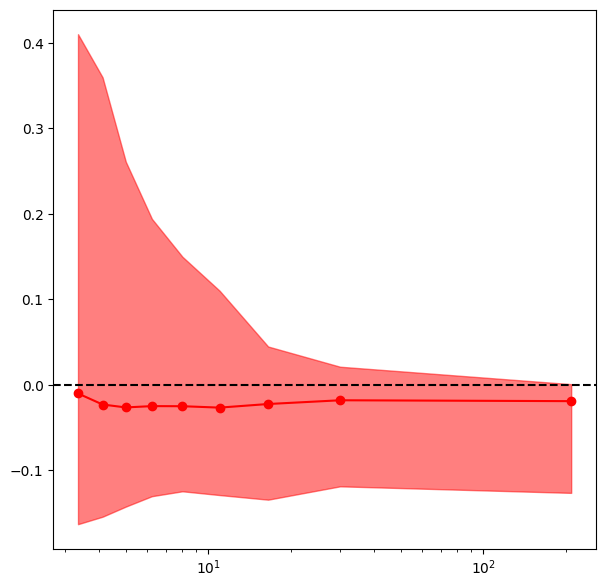

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7,7))
ax.plot(10**snr_middle, m, marker="o", color="r")
ax.fill_between(10**snr_middle, q1, q2, color="r", alpha=0.5)
ax.set_xscale("log")
ax.axhline(0.0, linestyle='--', color='k')


In [ ]:
10**snr_bins

tensor([  3.0002,   3.7493,   4.5264,   5.5335,   7.0104,   9.2204,  13.0776,
         20.7847,  43.6668, 996.8664])

In [ ]:
snr.shape

torch.Size([44350])

In [ ]:
_mask = (_snr > 3.0 ) & (_snr < 3.7685)
_res1 = _res[:, _mask]

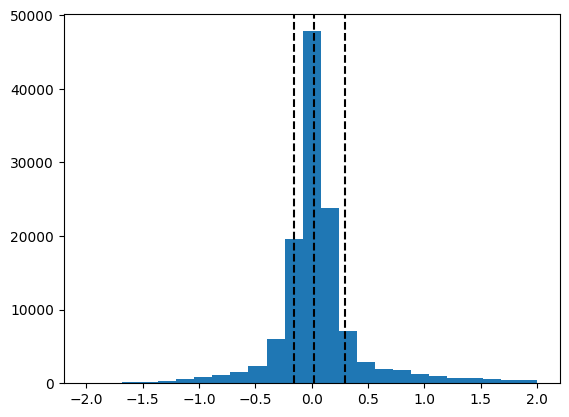

In [ ]:
plt.hist(_res1.ravel(), bins=25, range=(-2, 2))
plt.axvline(_res1.ravel().nanmedian(), linestyle='--', color='k')
plt.axvline(_res1.ravel().nanquantile(0.159), linestyle='--', color='k')
plt.axvline(_res1.ravel().nanquantile(0.841), linestyle='--', color='k')

In [ ]:
bld_mask = (bld > 1e-2) * (bld <= 1)
_bld = bld[bld_mask]
qs = torch.linspace(0, 1, 10)
bld_bins = torch.quantile(_bld, qs)
bld_middle = (bld_bins[1:] + bld_bins[:-1]) / 2


In [ ]:
bld_bins

tensor([0.0100, 0.0185, 0.0323, 0.0540, 0.0891, 0.1464, 0.2392, 0.3890, 0.6257,
        0.9993])

In [ ]:
f1 = rearrange(tflux, 'n -> 1 n')
res = (sfluxes - f1) / f1
_res = res[:, bld_mask]
_res.shape, res.shape

(torch.Size([100, 36327]), torch.Size([100, 44350]))

In [ ]:
m, q1, q2 = _calculate_statistics(_res, _bld, bld_bins)

(0.0, 2.0)

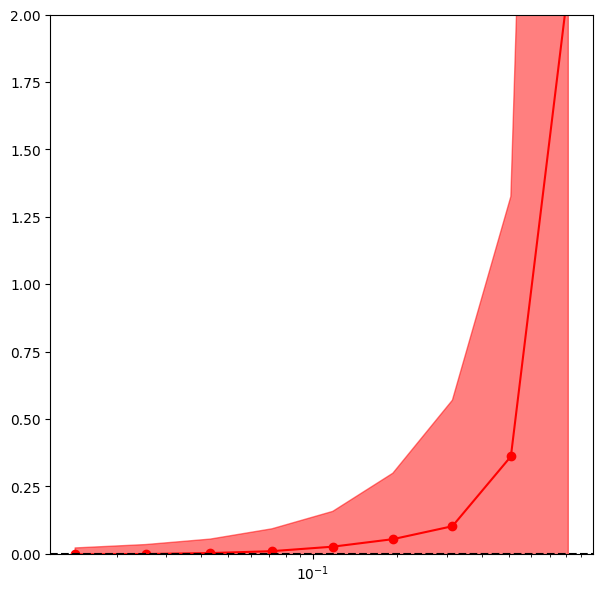

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7,7))
ax.plot(bld_middle, m, marker="o", color="r")
ax.fill_between(bld_middle, q1, q2, color="r", alpha=0.5)
ax.set_xscale("log")
ax.axhline(0.0, linestyle='--', color='k')

plt.ylim(0, 2)

## Sizes

In [ ]:
mask = (ds['snr'][:, 0] > 0) & (ds['truth']['galaxy_bools'][:, 0].bool())

tsize = ds['truth']['sigma'][mask, 0]
ssizes = ds['samples']['sigma'][:, mask, 0]
tflux.shape, sfluxes.shape
snr = ds['snr'][mask, 0]

snr.shape, tsize.shape, ssizes.shape

(torch.Size([44350]), torch.Size([44350]), torch.Size([100, 44350]))

In [ ]:
snr_mask = (snr > 3) * (snr <= 1000)
_snr = snr[snr_mask]
_snr_log = torch.log10(_snr)
qs = torch.linspace(0, 1, 10)
snr_bins = torch.quantile(_snr_log, qs)
snr_middle = (snr_bins[1:] + snr_bins[:-1]) / 2

In [ ]:
s1 = rearrange(tsize, 'n -> 1 n')
res = (ssizes - s1) / s1
_res = res[:, snr_mask]
_res.shape, res.shape

(torch.Size([100, 37645]), torch.Size([100, 44350]))

In [ ]:
m, q1, q2 = _calculate_statistics(_res, _snr_log, snr_bins)

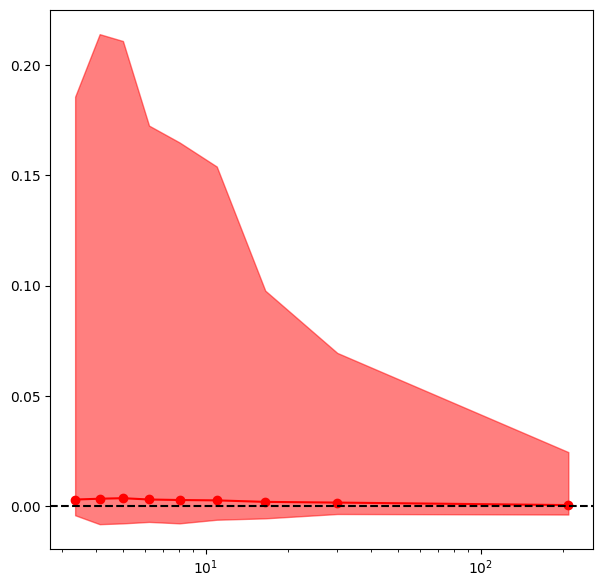

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7,7))
ax.plot(10**snr_middle, m, marker="o", color="r")
ax.fill_between(10**snr_middle, q1, q2, color="r", alpha=0.5)
ax.set_xscale("log")
ax.axhline(0.0, linestyle='--', color='k')


In [ ]:
bld_mask = (bld > 1e-2) * (bld <= 1)
_bld = bld[bld_mask]
qs = torch.linspace(0, 1, 10)
bld_bins = torch.quantile(_bld, qs)
bld_middle = (bld_bins[1:] + bld_bins[:-1]) / 2


In [ ]:
bld_bins

tensor([0.0100, 0.0185, 0.0323, 0.0540, 0.0891, 0.1464, 0.2392, 0.3890, 0.6257,
        0.9993])

In [ ]:
s1 = rearrange(tsize, 'n -> 1 n')
res = (ssizes - s1) / s1
_res = res[:, bld_mask]
_res.shape, res.shape

(torch.Size([100, 36327]), torch.Size([100, 44350]))

In [ ]:
m, q1, q2 = _calculate_statistics(_res, _bld, bld_bins)

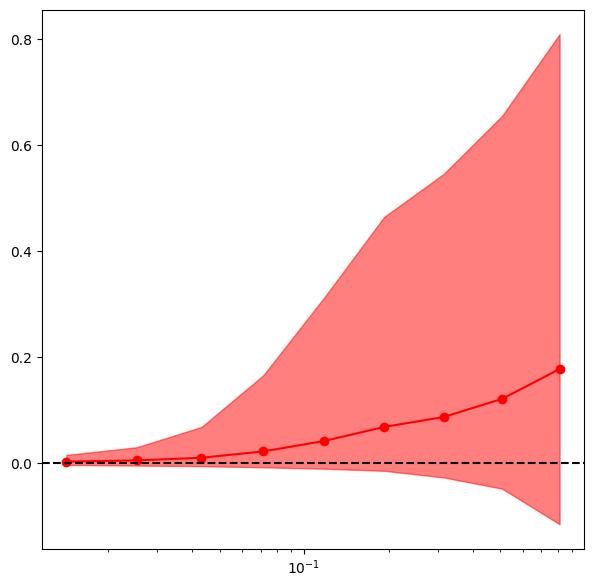

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7,7))
ax.plot(bld_middle, m, marker="o", color="r")
ax.fill_between(bld_middle, q1, q2, color="r", alpha=0.5)
ax.set_xscale("log")
ax.axhline(0.0, linestyle='--', color='k')


## Ellipticity

In [ ]:
ds['truth']['ellips'].shape

torch.Size([44429, 2])

In [ ]:
mask = (ds['snr'][:, 0] > 0) & (ds['truth']['galaxy_bools'][:, 0].bool())

te1 = ds['truth']['ellips'][mask, 0]
se1 = ds['samples']['ellips'][:, mask, 0]
snr = ds['snr'][mask, 0]

snr.shape, te1.shape, se1.shape

(torch.Size([44350]), torch.Size([44350]), torch.Size([100, 44350]))

In [ ]:
snr_mask = (snr > 3) * (snr <= 1000)
_snr = snr[snr_mask]
_snr_log = torch.log10(_snr)
qs = torch.linspace(0, 1, 10)
snr_bins = torch.quantile(_snr_log, qs)
snr_middle = (snr_bins[1:] + snr_bins[:-1]) / 2

In [ ]:
e1 = rearrange(te1, 'n -> 1 n')
res = se1 - e1
_res = res[:, snr_mask]
_res.shape, res.shape

(torch.Size([100, 37645]), torch.Size([100, 44350]))

In [ ]:
m, q1, q2 = _calculate_statistics(_res, _snr_log, snr_bins)

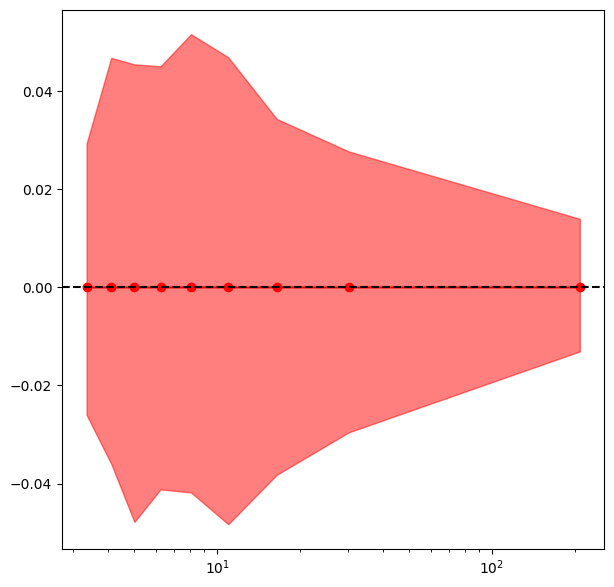

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7,7))
ax.plot(10**snr_middle, m, marker="o", color="r")
ax.fill_between(10**snr_middle, q1, q2, color="r", alpha=0.5)
ax.set_xscale("log")
ax.axhline(0.0, linestyle='--', color='k')


In [ ]:
bld_mask = (bld > 1e-2) * (bld <= 1)
_bld = bld[bld_mask]
qs = torch.linspace(0, 1, 10)
bld_bins = torch.quantile(_bld, qs)
bld_middle = (bld_bins[1:] + bld_bins[:-1]) / 2


In [ ]:
e1 = rearrange(te1, 'n -> 1 n')
res = se1 - e1
_res = res[:, bld_mask]
_res.shape, res.shape

(torch.Size([100, 36327]), torch.Size([100, 44350]))

In [ ]:
m, q1, q2 = _calculate_statistics(_res, _bld, bld_bins)

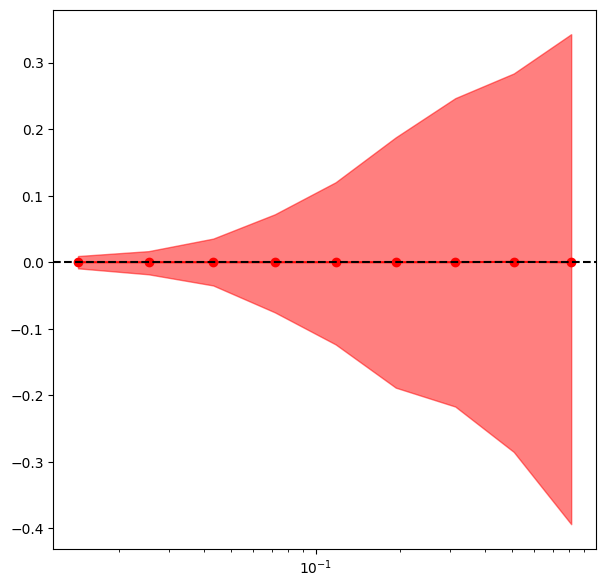

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7,7))
ax.plot(bld_middle, m, marker="o", color="r")
ax.fill_between(bld_middle, q1, q2, color="r", alpha=0.5)
ax.set_xscale("log")
ax.axhline(0.0, linestyle='--', color='k')


## Look at one object at a time 


In [ ]:
mask = (ds['snr'][:, 0] > 10) & (ds['truth']['galaxy_bools'][:, 0].bool()) & (ds['snr'][:, 0] < 1000)

tflux = ds['truth']['flux'][mask, 0]
sfluxes = ds['samples']['flux'][:, mask, 0]
tflux.shape, sfluxes.shape
snr = ds['snr'][mask, 0]
bld = ds['bld'][mask, 0]

snr.shape, sfluxes.shape, tflux.shape, bld.shape

(torch.Size([15680]),
 torch.Size([100, 15680]),
 torch.Size([15680]),
 torch.Size([15680]))

In [ ]:
snr[idx]

NameError: name 'idx' is not defined

In [ ]:
cts

array([ 1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
        0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  9., 18.])

tensor(11.1417)


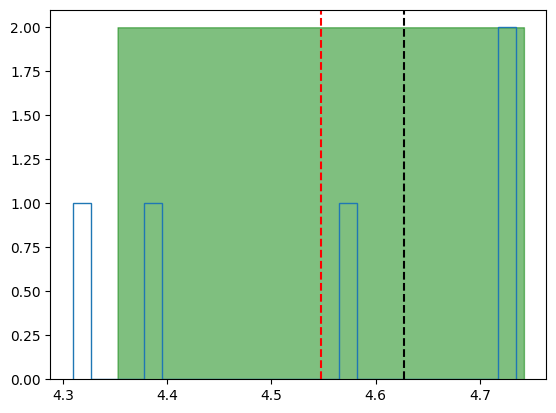

In [ ]:
import numpy as np
idx = np.random.randint(0, len(snr))


sflux = sfluxes[:, idx].log10()
_tflux = tflux[idx].log10()


print(snr[idx])

cts, bins, _ = plt.hist(sflux, histtype='step', bins=25)


mask = ~torch.isnan(sflux)

_mean = sflux[mask].mean()
_std = sflux[mask].std()
# x1 = torch.quantile(sflux[mask], q=0.05)
# x2 = torch.quantile(sflux[mask], q=0.95)

x = np.linspace(_mean - _std, _mean + _std, 1000)
plt.fill_between(x, 0, cts.max(), color='green', alpha=0.5)


plt.axvline(_mean, color='r', linestyle='--')
plt.axvline(_tflux, color='k', linestyle='--')


In [ ]:
_mean

tensor(5.0224)

In [ ]:
sflux[mask]

tensor([4.7922, 4.7937, 4.7877, 4.7928, 4.7923, 4.7917, 4.7920, 4.7860, 4.7912,
        4.7919, 4.7913, 4.7887, 4.7848, 4.7929, 4.7933, 4.7878, 4.7856, 4.7676,
        4.7890, 4.7917, 4.7764, 4.7877, 4.7830, 4.7862, 4.7872, 4.7897, 4.7866,
        4.7923, 4.7890, 4.7886, 4.7940, 4.7908, 4.7852, 4.7819, 4.7908, 4.7927,
        4.7866, 4.7881, 4.7932, 4.7879, 4.7743, 4.7879, 4.7911, 4.7918, 4.7889,
        4.7906, 4.7897, 4.7892, 4.7915, 4.7913, 4.7936, 4.7905, 4.7895, 4.7909,
        4.7876, 4.7930, 4.7825, 4.7911, 4.7917, 4.7851, 4.7930, 4.7850, 4.7922,
        4.7914, 4.7899, 4.7876, 4.7913, 4.7891, 4.7827, 4.7896, 4.7907, 4.7891,
        4.7882, 4.7893, 4.7885, 4.7886, 4.7876, 4.7931, 4.7900, 4.7889, 4.7911,
        4.7909, 4.7731, 4.7894, 4.7896, 4.7867, 4.7884, 4.7895, 4.7863, 4.7864,
        4.7909, 4.7914, 4.7862])

## Try weighted

In [ ]:
# https://en.wikipedia.org/wiki/Weighted_arithmetic_mean#Variance-defined_weights

In [ ]:

# bins
snr_mask = (snr > 3) * (snr <= 1000) * (~torch.isnan(sfluxes.nanmean(axis=0)))
_snr = snr[snr_mask]
_snr_log = torch.log10(_snr)
qs = torch.linspace(0, 1, 10)
snr_bins = torch.quantile(_snr_log, qs)
snr_middle = (snr_bins[1:] + snr_bins[:-1]) / 2


In [ ]:
_snr_log.shape

torch.Size([37282])

In [ ]:
from tqdm import tqdm
f1 = rearrange(tflux, 'n -> 1 n')

ws = []
for ii in tqdm(range(len(tflux))):
    mask = ~torch.isnan(sfluxes[:, ii])
    if sum(mask) > 1:
        std = sfluxes[mask, ii].std().item() / torch.sqrt(sum(mask))
        ws.append(1/std**2)
    else: 
        ws.append(0.0)

ws = torch.tensor(ws)

100%|██████████| 44350/44350 [00:51<00:00, 861.30it/s]


In [ ]:
ws.shape

torch.Size([44350])

In [ ]:
tflux.shape

torch.Size([44350])

In [ ]:
sfluxes.shape

torch.Size([100, 44350])

In [ ]:
_snr_log.shape
_ws = ws[snr_mask]
_sfluxes = sfluxes[:, snr_mask]
_tflux = tflux[snr_mask]
_sfluxes.shape, _tflux.shape

(torch.Size([100, 37282]), torch.Size([37282]))

In [ ]:
sum(torch.isnan(_sfluxes.nanmean(axis=0)))

tensor(0)

In [ ]:
def get_weightd_quantities(x, y, weights, x_bins): 

    wm = [] 
    wstd = []

    for ii in range(len(x_bins) - 1):
        _mask = (x > x_bins[ii]) * (x < x_bins[ii + 1])
        y_masked = y[:, _mask].nanmean(axis=0)
        mean = torch.sum(weights[mask] * y_masked)

    return torch.tensor(medians), torch.tensor(q1s), torch.tensor(q3s)

## Correlations (fluxes)

In [ ]:
_snr.shape, _fluxes.shape

(torch.Size([44429]), torch.Size([100, 44429, 1]))

In [ ]:
# calculate std ignorning nan's or just 1 value available in fluxes
stds_s = [] 
stds_q = []
for ii in tqdm(range(_fluxes.shape[1])):
    f = _fluxes[:, ii, 0]
    mask = torch.isnan(f)
    if sum(mask) == len(f) or sum(mask) == len(f) - 1: 
        stds_s.append(torch.nan)
        stds_q.append(torch.nan)
    else: 
        stds_s.append(torch.std(f[~mask]))
        stds_q.append(f.nanquantile(q=0.841) - f.nanquantile(q=0.159))
    
    

100%|██████████| 44429/44429 [01:22<00:00, 537.30it/s]


In [ ]:
stds = torch.tensor(stds_s)
stds.shape, sum(stds.isnan())

(torch.Size([44429]), tensor(2081))

In [ ]:
std_norm = stds / torch.sqrt( _fluxes.nanmean(axis=0)[:, 0]  + fluxerr**2 )

(array([3.0000e+00, 1.2000e+01, 6.4000e+01, 2.3500e+03, 1.8331e+04,
        1.5111e+04, 5.0840e+03, 1.1710e+03, 2.0400e+02, 1.8000e+01]),
 array([0.25447148, 0.93166405, 1.60885668, 2.28604913, 2.96324182,
        3.6404345 , 4.31762648, 4.99481916, 5.67201185, 6.34920454,
        7.02639675]),
 <BarContainer object of 10 artists>)

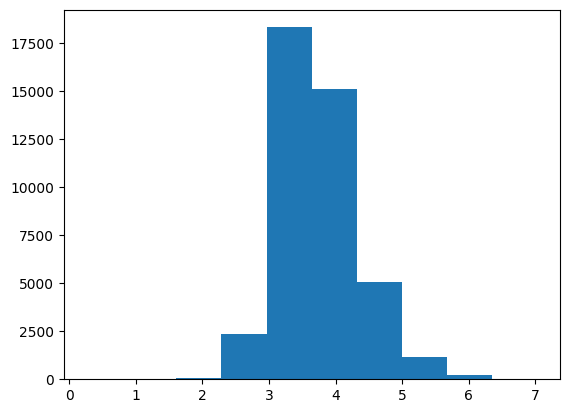

In [ ]:
std_mask = ~torch.isnan(stds)
plt.hist(stds[std_mask].log10())

(array([3.0000e+00, 1.2000e+01, 5.2000e+01, 1.6400e+03, 1.6638e+04,
        1.6135e+04, 6.0680e+03, 1.4920e+03, 2.8600e+02, 2.2000e+01]),
 array([-3.32505608, -2.66356611, -2.00207615, -1.34058642, -0.67909646,
        -0.0176065 ,  0.64388323,  1.30537319,  1.96686316,  2.62835312,
         3.28984308]),
 <BarContainer object of 10 artists>)

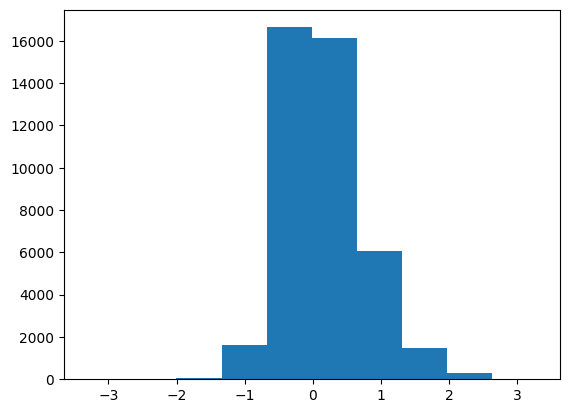

In [ ]:
std_mask = ~torch.isnan(std_norm)
plt.hist(std_norm[std_mask].log10())

In [ ]:
np.linspace(0, 1, 11)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [ ]:
def _calculate_statistics(y, x, x_bins, qs=(0.159, 0.841)):
    medians, q1s, q3s = [], [], []
    for ii in range(len(x_bins) - 1):
        _mask = (x > x_bins[ii]) * (x < x_bins[ii + 1])
        masked_y = y[_mask]
        medians.append(np.median(masked_y))
        q1s.append(np.quantile(masked_y, qs[0]))
        q3s.append(np.quantile(masked_y, qs[1]))
    return np.array(medians), np.array(q1s), np.array(q3s)

Text(0.5, 0, 'SNR')

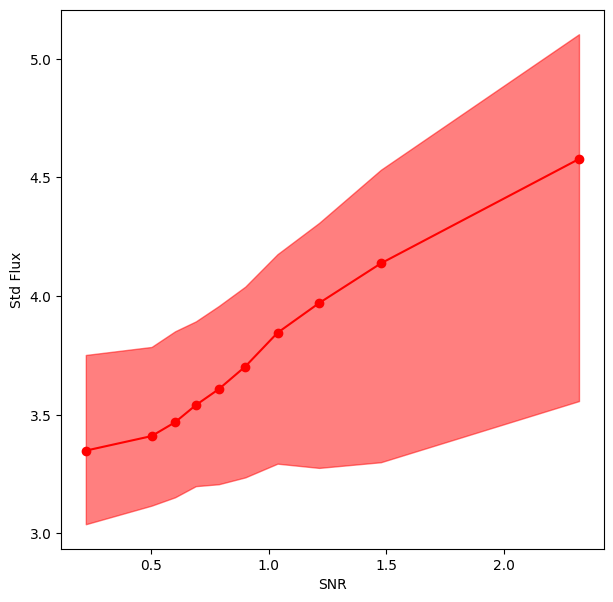

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

x = _snr[std_mask].log10()
y = stds[std_mask].log10()

# equal number of objects
n_bins=10
x_mask = (x > 0) * (x <= 3)
_x = x[x_mask]
qs = np.linspace(0, 1, n_bins+1)
x_bins = np.quantile(_x, qs)
x_middle = (x_bins[1:] + x_bins[:-1]) / 2
meds1, y1, y2 = _calculate_statistics(y[x_mask], _x, x_bins)

ax.plot(x_middle, meds1, '-ro')
ax.fill_between(x_middle, y1, y2, color="r", alpha=0.5)

ax.set_ylabel("Std Flux")
ax.set_xlabel("SNR")

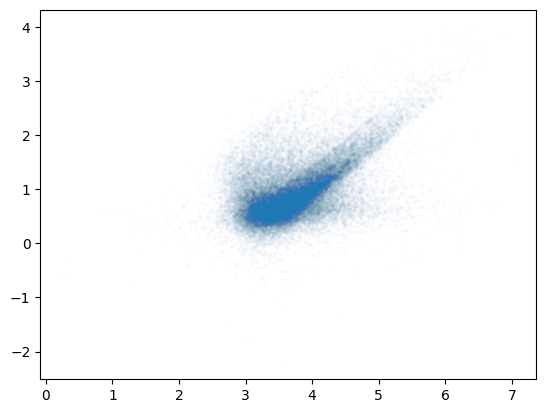

In [ ]:
# TODO: add 2d histogram 

plt.scatter(stds[std_mask].log10(), _snr[std_mask].log10(), s=3, alpha=0.01)

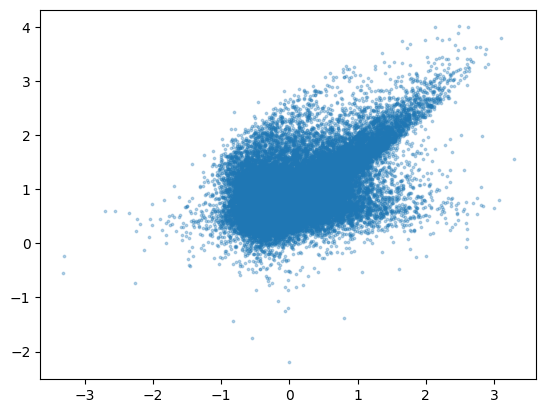

In [ ]:
plt.scatter(std_norm[std_mask].log10(), _snr[std_mask].log10(), s=3, alpha=0.3)

In [ ]:
from scipy.stats import spearmanr 
spearmanr(std_norm[std_mask].log10(), _snr[std_mask].log10())

SignificanceResult(statistic=np.float64(0.4661026846608213), pvalue=np.float64(0.0))

In [ ]:
from bliss.plotting import scatter_shade_plot
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
scatter_shade_plot(ax, bld[std_mask].log10(), stds[std_mask].log10(),  delta=0.1, xlims=(3,5.5))

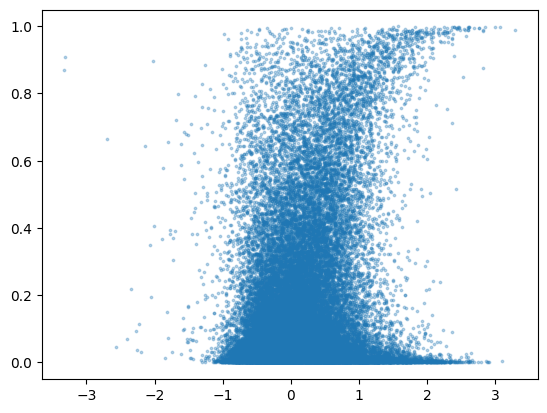

In [ ]:
plt.scatter(std_norm[std_mask].log10(), _bld[std_mask], s=3, alpha=0.3)

Text(0.5, 0, 'B')

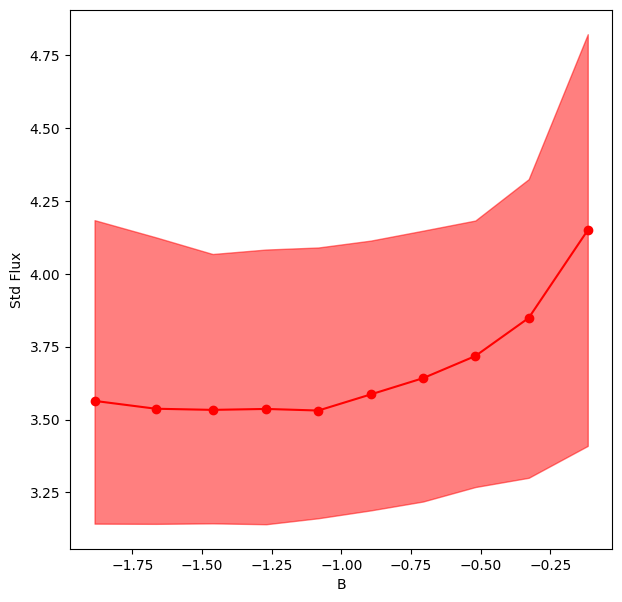

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

x = _bld[std_mask].log10()
y = stds[std_mask].log10()

# equal number of objects
n_bins=10
x_mask = (x > -2) * (x <= 1)
_x = x[x_mask]
qs = np.linspace(0, 1, n_bins+1)
x_bins = np.quantile(_x, qs)
x_middle = (x_bins[1:] + x_bins[:-1]) / 2
meds1, y1, y2 = _calculate_statistics(y[x_mask], _x, x_bins)

ax.plot(x_middle, meds1, '-ro')
ax.fill_between(x_middle, y1, y2, color="r", alpha=0.5)

ax.set_ylabel("Std Flux")
ax.set_xlabel("B")

In [ ]:
from scipy.stats import spearmanr 
spearmanr(std_norm[std_mask], _bld[std_mask]), spearmanr(stds[std_mask], _bld[std_mask])

(SignificanceResult(statistic=np.float64(0.09824448419249959), pvalue=np.float64(2.576770202771548e-91)),
 SignificanceResult(statistic=np.float64(0.0974393404541427), pvalue=np.float64(7.540337077484752e-90)))

In [ ]:
# check correlation with residuals
mask = (ds['snr'][:, 0] > 0) & (ds['truth']['galaxy_bools'][:, 0].bool())
mask2 = mask & std_mask
sum(mask2)

tensor(42327)

In [ ]:
tflux = ds['truth']['flux'][mask2, 0]
_fluxes2 = _fluxes[:, mask2, 0]
_std = std_norm[mask2]
_std2 = stds[mask2]

tflux.shape, _fluxes2.shape, _std.shape, _std2.shape


(torch.Size([42327]),
 torch.Size([100, 42327]),
 torch.Size([42327]),
 torch.Size([42327]))

In [ ]:
res = torch.abs( (_fluxes2.nanmean(0) - tflux) / (tflux + fluxerr**2) ) 
res2 = torch.abs( (_fluxes2.nanmean(0) - tflux) / tflux )
res3 =torch.abs( (_fluxes2.nanmean(0) - tflux))

In [ ]:
spearmanr(_std, res), spearmanr(_std2, res)

(SignificanceResult(statistic=np.float64(0.6913009832123977), pvalue=np.float64(0.0)),
 SignificanceResult(statistic=np.float64(0.6914356720896884), pvalue=np.float64(0.0)))

In [ ]:
spearmanr(_std, res2), spearmanr(_std2, res2)

(SignificanceResult(statistic=np.float64(0.31952602512073264), pvalue=np.float64(0.0)),
 SignificanceResult(statistic=np.float64(0.31850006962317284), pvalue=np.float64(0.0)))

In [ ]:
plt.scatter(_std.log10(), res.log10(), s=3, alpha=0.3)
plt.

SyntaxError: invalid syntax (744874932.py, line 2)

Text(0, 0.5, 'Log Residuals')

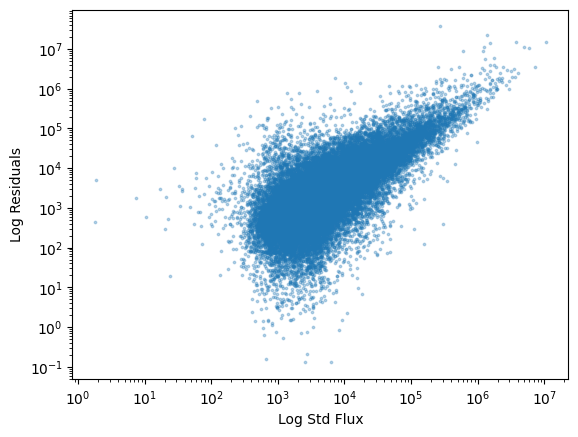

In [ ]:
plt.scatter(_std2, res3, s=3, alpha=0.3)
plt.xscale('log')
plt.yscale('log')
# plt.axvline(10**5, color='k')
# plt.axhline(10**5, color='k')
plt.xlabel("Log Std Flux")
plt.ylabel("Log Residuals")

In [ ]:
res3.shape, _std2.shape

(torch.Size([42327]), torch.Size([42327]))

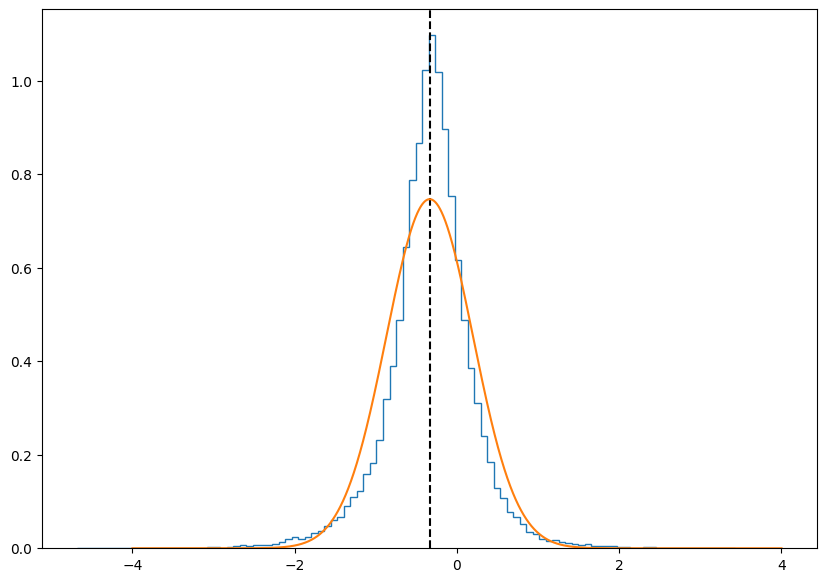

In [ ]:
import scipy.stats as stats
plt.figure(figsize=(10,7))

x = (res3 / _std2).log10()
plt.hist(x, bins = 101, histtype='step', density=True);
plt.axvline(x.mean(), linestyle='--', color='k')
_x = np.linspace(-4, 4, 10000)
plt.plot(_x, stats.norm.pdf(_x, x.mean(), x.std()))


In [ ]:
# calibration of magnitudes?!?!
# see next section

## Correlations (magnitudes)

In [ ]:
_mags = convert_flux_to_mag(_fluxes)

/home/imendoza/bliss/.venv/lib/python3.10/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))


In [ ]:
# calculate std ignorning nan's or just 1 value available in fluxes
stds_s = [] 
stds_q = []
for ii in tqdm(range(_fluxes.shape[1])):
    m = _mags[:, ii, 0]
    mask = ~torch.isnan(m)
    if sum(mask) <  2:
        stds_s.append(torch.nan)
        stds_q.append(torch.nan)
    else: 
        stds_s.append(torch.std(m[mask]))
        stds_q.append(m.nanquantile(q=0.841) - m.nanquantile(q=0.159))
    
    

100%|██████████| 44429/44429 [00:33<00:00, 1308.68it/s]


In [ ]:
stds = torch.tensor(stds_s)
stds.shape, sum(stds.isnan())

(torch.Size([44429]), tensor(2264))

(array([3.1813e+04, 7.9550e+03, 1.8150e+03, 3.9300e+02, 1.2100e+02,
        3.9000e+01, 2.0000e+01, 5.0000e+00, 1.0000e+00, 3.0000e+00]),
 array([2.83712683e-04, 4.98155816e-01, 9.96027920e-01, 1.49390002e+00,
        1.99177213e+00, 2.48964423e+00, 2.98751633e+00, 3.48538844e+00,
        3.98326054e+00, 4.48113264e+00, 4.97900475e+00]),
 <BarContainer object of 10 artists>)

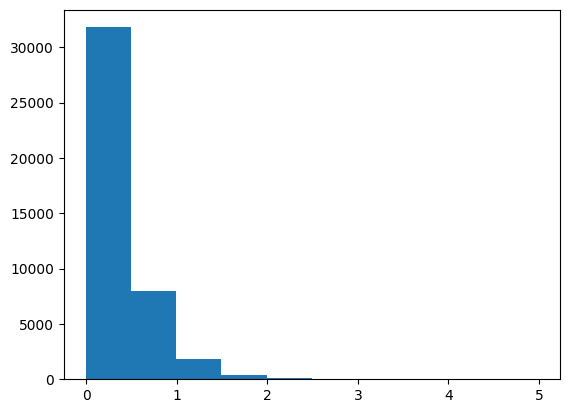

In [ ]:
std_mask = ~torch.isnan(stds)
plt.hist(stds[std_mask])

In [ ]:
# check correlation with residuals
mask = (ds['snr'][:, 0] > 0) & (ds['truth']['galaxy_bools'][:, 0].bool())
mask2 = mask & std_mask
sum(mask2)

tensor(42148)

In [ ]:
_mags.shape

torch.Size([100, 44429, 1])

In [ ]:
tmags = convert_flux_to_mag(ds['truth']['flux'][mask2, 0])
_mags2 = _mags[:, mask2, 0]
_std = stds[mask2]

tmags.shape, _mags2.shape, _std.shape

(torch.Size([42148]), torch.Size([100, 42148]), torch.Size([42148]))

In [ ]:
res = _mags2.nanmean(0) - tmags

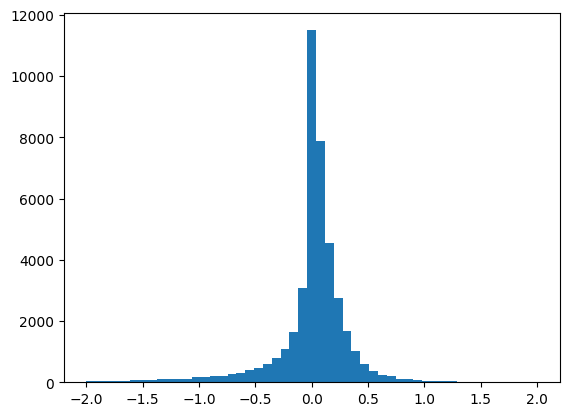

In [ ]:
plt.hist(res, bins=51, range=(-2, 2));

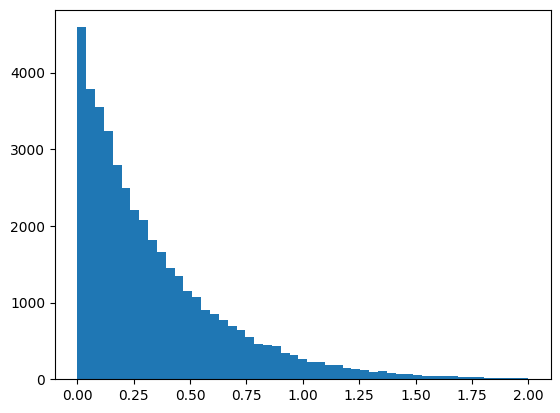

In [ ]:
plt.hist(_std, bins=51, range=(0, 2));

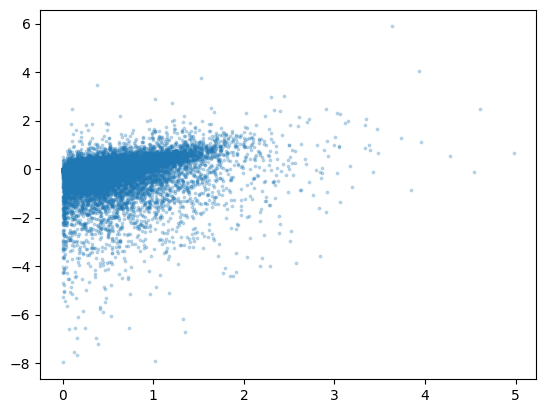

In [ ]:
plt.scatter( _std, res, marker='o', s=3, alpha=0.25)

(array([4.0000e+00, 4.5000e+01, 1.6810e+03, 3.8679e+04, 1.3400e+03,
        2.7700e+02, 7.7000e+01, 3.0000e+01, 9.0000e+00, 6.0000e+00]),
 array([-4.40937598, -3.17180536, -1.93423474, -0.69666412,  0.5409065 ,
         1.77847712,  3.01604774,  4.25361836,  5.49118898,  6.7287596 ,
         7.96633022]),
 <BarContainer object of 10 artists>)

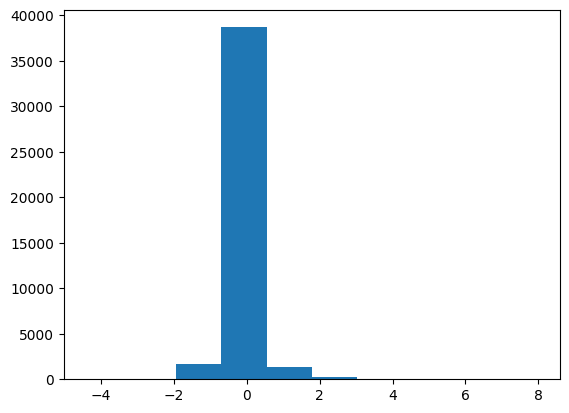

In [ ]:
plt.hist( torch.abs(res)  - _std)

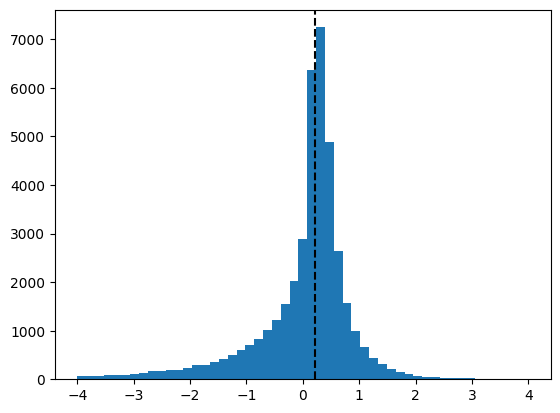

In [ ]:
plt.hist( res /  _std, range=(-4, 4), bins=51);
plt.axvline((res/_std).median(), color='k', linestyle='--')

## Calibration 